# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 12,01


### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [134]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [135]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [136]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: поскольку это предсказание вероятности принадлежности к положительному классу, что находится в промежутке от 0 до 1, как мы знаем из теории вероятностей.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [137]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


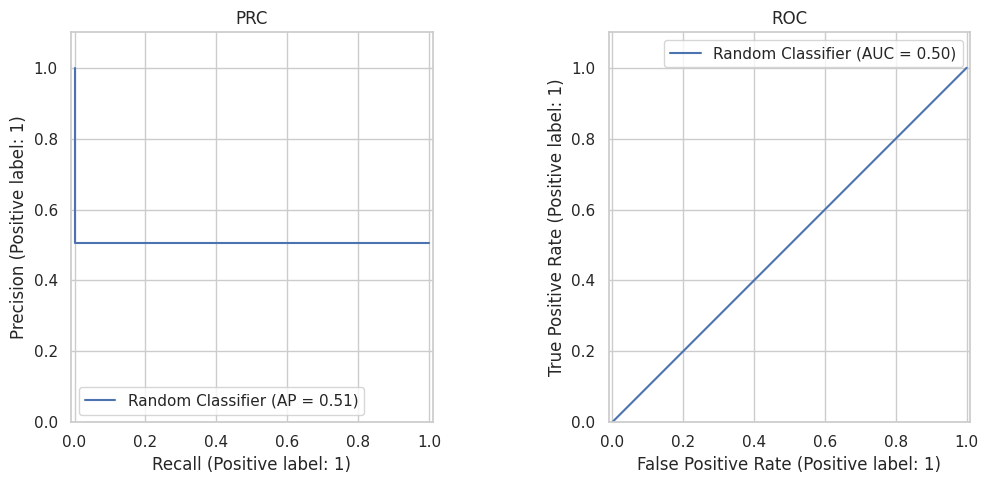

In [138]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [139]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [140]:
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
param_grid = {'C': np.logspace(-3, 3, 7)}
svc = LinearSVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='average_precision')
grid_search.fit(X_train, y_train)
best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
svc_pred = best_model.decision_function(X_test)

print(f"Лучший параметр C: {best_C}")
print(f"Лучший AUC-PR: {best_score}")
print('SVC ROC-AUC:', roc_auc_score(y_test, svc_pred))


Лучший параметр C: 0.01
Лучший AUC-PR: 0.8233604335050156
SVC ROC-AUC: 0.8476230946997192


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

SVC Classifier metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476


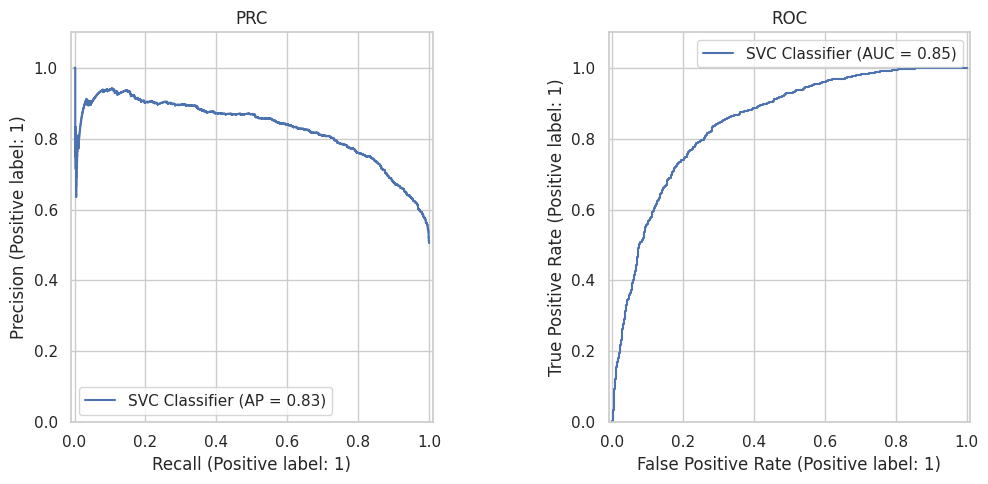

In [141]:
depict_pr_roc(y_test, svc_pred, 'SVC Classifier')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

В начале, когда модель предсказывает много положительных случаев, точность остается высокой, но по мере увеличения числа предсказанных положительных случаев (и, следовательно, увеличения числа ложноположительных), точность начинает падать, поэтому PRC кривая выглядит таким образом. Возможно, модель чрезмерно оптимистична.

PRC кривая не является монотонной, по причинам изложенным выше. С ростом количества положительно предсказанных значений ее точность начинает падать. ROC кривая монотонно возрастает, что хорошо:)


Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [142]:
df_metrics.loc['Linear SVC'] = [
    best_score,
    roc_auc_score(y_test, svc_pred),
    best_C,
]

print(df_metrics)

                     auc_pr  roc_auc_score  reg_const
Random Classifier  0.505667       0.500000       0.00
Linear SVC         0.823360       0.847623       0.01


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [143]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': np.logspace(-3, 3, 7)}
log_reg = LogisticRegression(penalty='l2', solver='liblinear')
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='average_precision')
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']
best_model = grid_search.best_estimator_
y_pred_logreg = best_model.predict_proba(X_test)[:, 1]

best_auc_pr = average_precision_score(y_test, y_pred_logreg)
best_roc_auc = roc_auc_score(y_test, y_pred_logreg)
df_metrics.loc['Logistic Regression L2'] = [
    best_auc_pr,
    best_roc_auc,
    best_C,
]

Logistic Regression with L2Reg metrics
AUC-PR: 0.8294
AUC-ROC: 0.8453


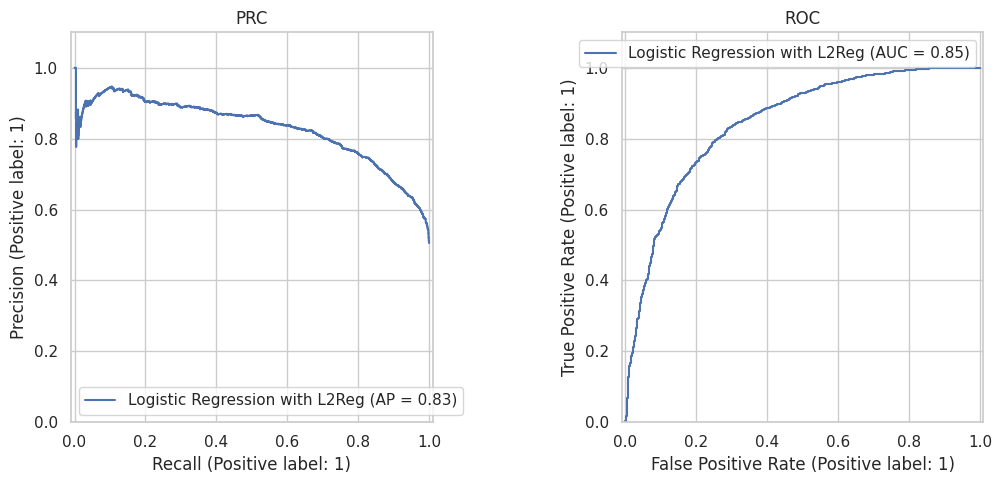

In [144]:
depict_pr_roc(y_test, y_pred_logreg, 'Logistic Regression with L2Reg')

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
LinearSVC metrics
AUC-PR: 0.8299
AUC-ROC: 0.8476
LogReg L2 metrics
AUC-PR: 0.8294
AUC-ROC: 0.8453


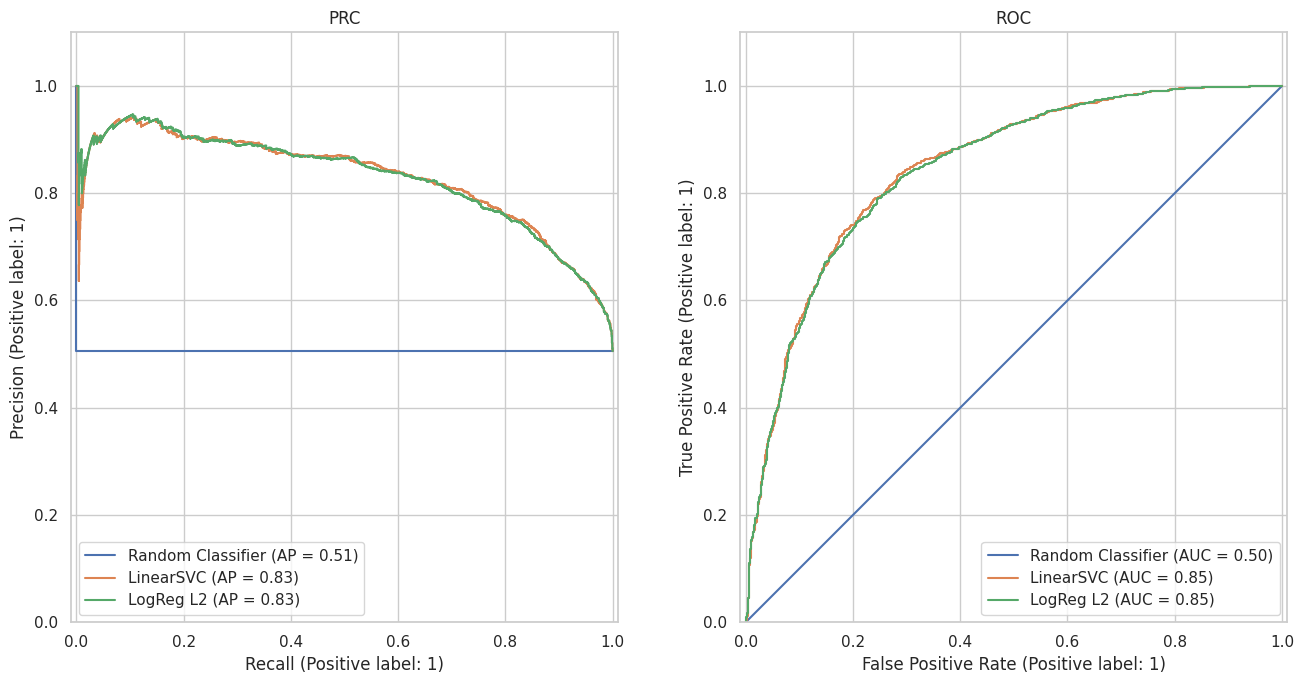

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)

depict_pr_roc(y_test, svc_pred, 'LinearSVC', ax=ax)

depict_pr_roc(y_test, y_pred_logreg, 'LogReg L2', ax=ax)

plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



In [146]:
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000
Linear SVC,0.823360,0.847623,0.010
Logistic Regression L2,0.829417,0.845298,0.001


**Ответ:**  как мы видим и из графика, и из расчетных метрик, разница между моделями пренебрежительно мала.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [147]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC

np.random.seed(42)

X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, random_state=0)

model = SVC(kernel='linear', random_state=0)
model.fit(X, y)

SVC(kernel='linear', random_state=0)

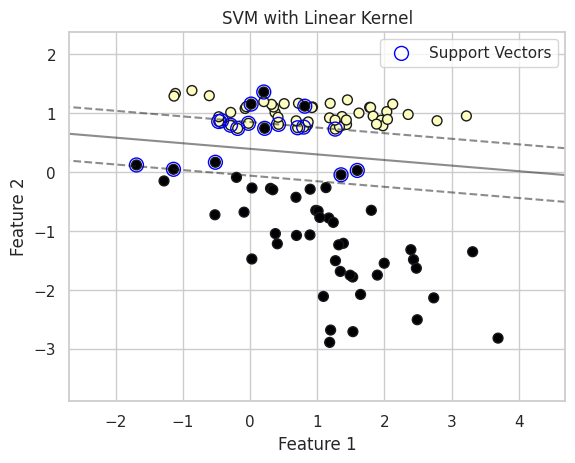

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.svm import SVC

def plot_svm_2D(X, y, model, plot_support=True):
    xx = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 30)
    yy = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='magma', edgecolors='k')
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            label='Support Vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.title('SVM with Linear Kernel')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()
np.random.seed(42)
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, random_state=0)

model = SVC(kernel='linear', random_state=0)
model.fit(X, y)
plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** как опорные выделяются объекты, которые наиболее сильно влияют на положение разделяющей плоскости. На графике они выделены синими окружностями вокруг точек. Благодаря ним мы делим класс черных точек и класс желтых точек.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

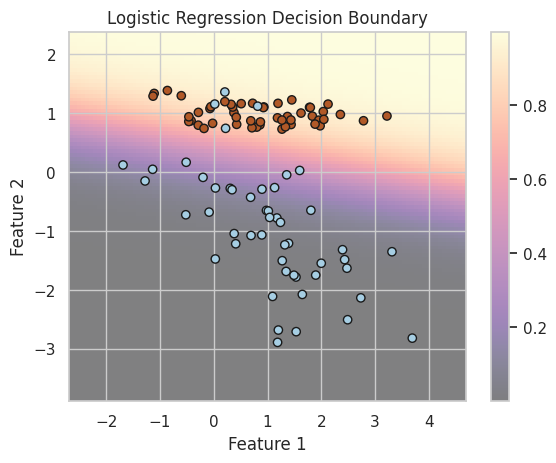

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

def plot_logreg_2D(X, y, model):
    # Создание сетки
    xx = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    yy = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]  # Вероятности принадлежности к классу 1
    Z = Z.reshape((xx.shape[0], -1)).T

    # Отрисовка распределения
    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap= 'magma',
        alpha=0.5
    )

    # Отрисовка выборки
    plt.scatter(
        X[:, 0], X[:, 1],
        c=y,
        cmap=plt.cm.Paired,
        edgecolors='k'
    )

    plt.colorbar(image)
    plt.title('Logistic Regression Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Генерация данных
np.random.seed(42)
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, random_state=0)

# Обучение модели логистической регрессии
model = LogisticRegression(solver='liblinear')
model.fit(X, y)

# Вызов функции для отрисовки
plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** на графике это выделено как разделяющая граница решения. В этой области модель не может дать однозначный вопрос о принадлежности к классу из-за равенства шансов точек попадания в оба класса.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [150]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)#не так считается матож
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) #надо считать среднее а не минимум
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot([0, 1], [0, 1], 'r--', label='Perfectly Calibrated', linewidth=2)
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.grid()
    plt.legend()
    plt.show()



Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

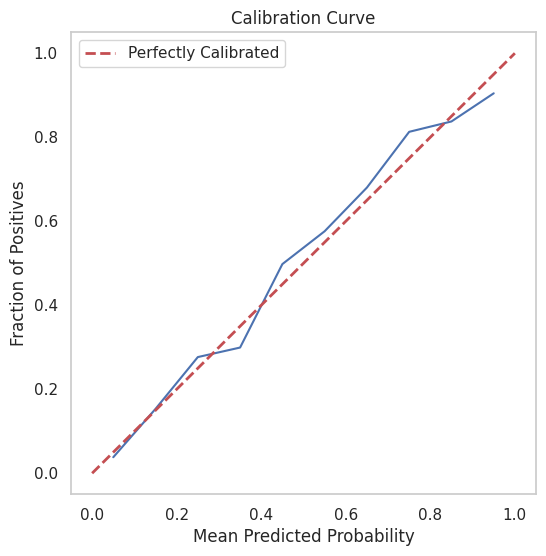

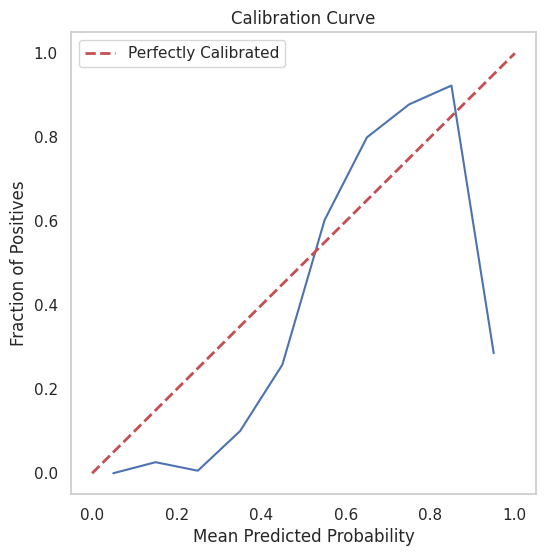

In [151]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_probs = lr_model.predict_proba(X_test)[:, 1]

svc_model = SVC(kernel = 'linear', probability=True)
svc_model.fit(X_train, y_train)

svc_probs = svc_model.decision_function(X_test)
svc_probs = (svc_probs - svc_probs.min()) / (svc_probs.max() - svc_probs.min())

plot_calibration_curve(y_test, lr_probs)
plot_calibration_curve(y_test, svc_probs)

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Для логистической регрессии кривые откалиброваны действительно неплохо. Для метода опорных векторов уже сильно хуже, это видно на графике.
SVM изначально не предоставляет вероятностные оценки; для этого требуется дополнительная калибровка, в то время как логистическая регрессия на выходе сразу позволяет оценивать вероятность принадлежности.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [152]:
y_test

array([1, 0, 0, ..., 0, 1, 1])

In [153]:
from sklearn.metrics import log_loss, brier_score_loss
svc_pred_proba = svc_model.predict_proba(X_test)[:, 1]
logloss_logistic = log_loss(y_test, y_pred_logreg)
logloss_svm = log_loss(y_test, svc_pred_proba)
brier_logistic = brier_score_loss(y_test, y_pred_logreg)
brier_svm = brier_score_loss(y_test, svc_pred_proba)
logloss_logistic


0.49476420907589264

In [154]:
logloss_svm

0.4872716786702199

In [155]:
brier_logistic

0.16264463180858124

In [156]:
brier_svm

0.15807748803461158

Как видно из метрик, модели действительно демонстрируют схожее поведение.  Чем больше предсказанная вероятность отклоняется от фактического значения, тем выше значение LogLoss, а чем меньше коэффициент Бриера, то тем более уверена в своих предсказаниях. В целом, SVM перформит чуть лучше по обеим метрикам, по сравнению с логистической регрессией.

Изучите распределение ответов классификаторов при помощи гистограмм

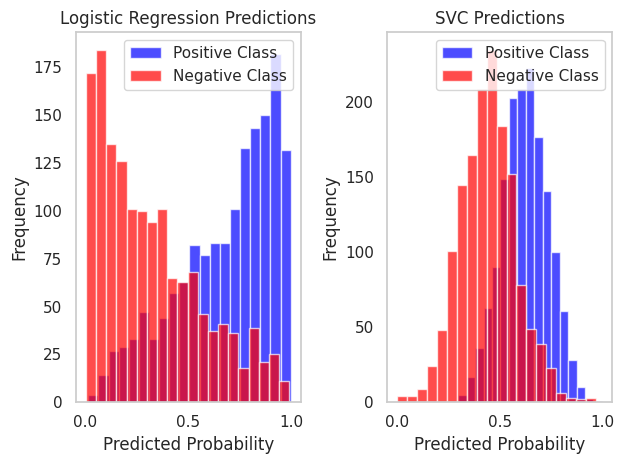

In [157]:
plt.subplot(1, 2, 1)
plt.hist(lr_probs[y_test == 1], bins=20, alpha=0.7, color='blue', label='Positive Class')
plt.hist(lr_probs[y_test == 0], bins=20, alpha=0.7, color='red', label='Negative Class')
plt.title('Logistic Regression Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(svc_probs[y_test == 1], bins=20, alpha=0.7, color='blue', label='Positive Class')
plt.hist(svc_probs[y_test == 0], bins=20, alpha=0.7, color='red', label='Negative Class')
plt.title('SVC Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** У логистической регрессии на самом деле более равномерное распределение оцененных вероятностей, с более четким делением на классы, что обеспечивает четкое размежевание между оценками для позитивного и негативного класса. У МОВ оценки больше похожи на нормальное распределение, и разница между оцененными значениями для двух классов оказывается сильно более маленькой. Кажется, что у МОВ больше неопределенности в предсказаниях, в то время как логрег больше уверен в том, что делает.


Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

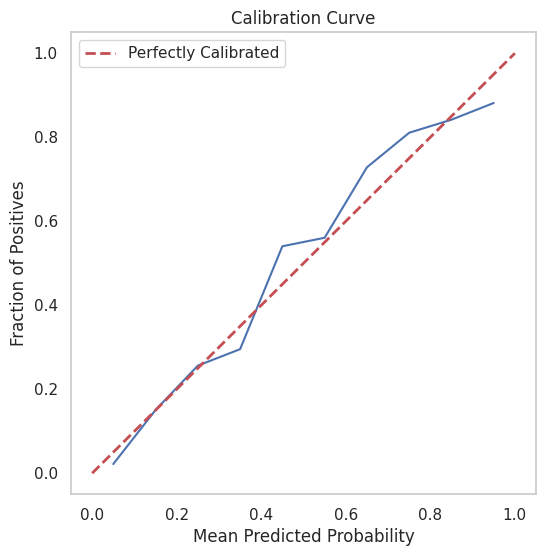

In [158]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(svc_model, method='sigmoid', cv='prefit')
calibrated_svc.fit(X_train, y_train)
svc_probs_calibrated = calibrated_svc.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, svc_probs_calibrated)

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Как видно из графика - да, причем сильно!

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

Мы использовали калибровку Платта, что, по сути, является добавлением дополнительного слоя логистической регрессии сверху на предикты модели SVM. Благодаря этому мы получаем более откалиброванные вероятности, чем без логистической регрессии.

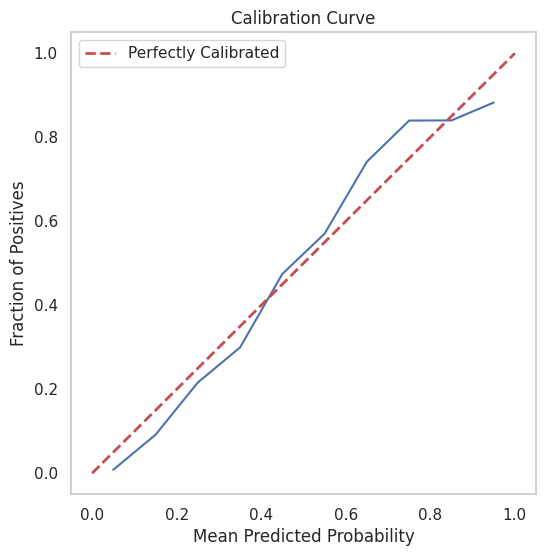

In [159]:
platt_model = LogisticRegression()
platt_model.fit(svc_probs.reshape(-1, 1), y_test)
calibrated_probs = platt_model.predict_proba(svc_probs.reshape(-1, 1))[:, 1]

plot_calibration_curve(y_test, calibrated_probs)

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [160]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [161]:
# Прочитаем датасет
data = pd.read_csv(path)

# Заменим пропуски категориальных переменных
for column in data.select_dtypes(include=['object']).columns:
    data[column].fillna('undefined', inplace=True)

# Отделим X и y
X = data.drop(columns=['Purchased Bike'])  # Все колонки, кроме целевой
y = (data['Purchased Bike'] == 'Yes').astype('int64') # Целевая переменная

# Разделим на категориальные признаки и числовые
X_numerical = X.select_dtypes(include=[np.number])
X_categorical = X.select_dtypes(include=['object'])
X_categorical = X_categorical.astype(str)

In [162]:
data.dtypes

,0
ID,int64
Marital Status,object
Gender,object
Income,float64
Children,float64
Education,object
Occupation,object
Home Owner,object
Cars,float64
Commute Distance,object


В начале поработаем только с категориальными признаками

In [163]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [164]:
from sklearn.preprocessing import OrdinalEncoder
from time import time
ordinal_encoder = OrdinalEncoder()
X_train = ordinal_encoder.fit_transform(X_train)
X_test = ordinal_encoder.transform(X_test)

# Обучение модели логистической регрессии
start_time = time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
end_time = time()

# Предсказание вероятностей для тестовой выборки
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)
training_time = end_time - start_time

auc_pr, training_time

(0.5886533539773633, 0.007857799530029297)

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [165]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
X_train = one_hot_encoder.fit_transform(X_train)
X_test = one_hot_encoder.transform(X_test)


start_time = time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
end_time = time()

y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

training_time = end_time - start_time

auc_pr, training_time

(0.6662544177340515, 0.014072656631469727)

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [166]:
def mean_target_encoding(X_train, y_train, X_test):
    X_train_ = X_train.copy()
    X_test_ = X_test.copy()
    X = pd.concat([X_train_, y_train.rename('target')], axis=1)
    category_means = {}
    for col in X_train_.columns:
        category_means[col] = X.groupby(col)['target'].mean()
    for col in X_train_.columns:
        X_train_[col] = X_train_[col].map(category_means[col])
        X_test_[col] = X_test_[col].map(category_means[col]).fillna(X_train_[col].mean())

    return X_train_, X_test_

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=42, stratify=y)
X_train_encoded, X_test_encoded = mean_target_encoding(X_train, y_train, X_test)

In [168]:
start_time = time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)
end_time = time()

y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

training_time = end_time - start_time

auc_pr, training_time

(0.6694578626670632, 0.010886430740356445)

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [169]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalCounter(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.statistics_ = {}

    def fit(self, X, y=None):
        for feature in self.categorical_features:
            self.statistics_[feature] = X[feature].value_counts(normalize=True).to_dict()
        return self

    def transform(self, X):
        X_transformed = X.copy()

        for feature in self.categorical_features:
            X_transformed[feature] = X_transformed[feature].map(self.statistics_[feature]).fillna(0)

        return X_transformed


In [170]:
counter_transformer = CategoricalCounter(X_categorical)
counter_transformer.fit(X_train, y_train)
X_train_encoded = counter_transformer.transform(X_train)
X_test_encoded = counter_transformer.transform(X_test)

In [171]:
start_time = time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)
end_time = time()

y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

training_time = end_time - start_time

auc_pr, training_time

(0.6428849021242772, 0.010899782180786133)

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [172]:
def mean_target_encoding_noisy(X_train, y_train, X_test, noise_level=0.01):
    X_train_ = X_train.copy()
    X_test_ = X_test.copy()
    X = pd.concat([X_train_, y_train.rename('target')], axis=1)
    category_means = {}
    for col in X_train_.columns:
        category_means[col] = X.groupby(col)['target'].mean()
    for col in X_train_.columns:
        noise = np.random.normal(0, noise_level, size=category_means[col].shape)
        category_means[col] += noise
    for col in X_train_.columns:
        X_train_[col] = X_train_[col].map(category_means[col])
        X_test_[col] = X_test_[col].map(category_means[col]).fillna(X_train_[col].mean())

    return X_train_, X_test_

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=42, stratify=y)

In [174]:
X_train_encoded, X_test_encoded = mean_target_encoding_noisy(X_train,y_train, X_test)

In [175]:
start_time = time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)
end_time = time()

y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

training_time = end_time - start_time

auc_pr, training_time

(0.6711997634594744, 0.007775306701660156)

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Да, стало чуть лучше: дело в том, что модель стала менее склонна к переобучению, что могло снижать качество на тестовой выборке.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [176]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalCounter_noisy(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, noise_level=0.01):
        self.categorical_features = categorical_features
        self.statistics_ = {}
        self.noise_level = noise_level

    def fit(self, X, y=None):
        for feature in self.categorical_features:
            self.statistics_[feature] = X[feature].value_counts(normalize=True).to_dict()
        return self

    def transform(self, X):
        X_transformed = X.copy()

        for feature in self.categorical_features:
            mapped_values = X_transformed[feature].map(self.statistics_[feature]).fillna(0)
            noise = np.random.normal(0, self.noise_level, size=mapped_values.shape)
            X_transformed[feature] = mapped_values + noise
            X_transformed[feature] = np.clip(X_transformed[feature], 0, 1)

        return X_transformed

In [177]:
counter_transformer = CategoricalCounter_noisy(X_categorical)
counter_transformer.fit(X_train, y_train)
X_train_encoded = counter_transformer.transform(X_train)
X_test_encoded = counter_transformer.transform(X_test)

In [178]:
start_time = time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)
end_time = time()

y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

training_time = end_time - start_time

auc_pr, training_time

(0.6352989245709935, 0.010991573333740234)

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [179]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state= 15, stratify=y)

In [180]:
class MeanTargetEncoderSmoothed(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, C= 1):
        self.categorical_columns = categorical_columns
        self.C = C
        self.mapping_dict = {}
        self.global_mean = None

    def fit(self, X, y):
        self.global_mean = y.mean()
        X_full = X.copy()
        X_full['target'] = y
        for col in self.categorical_columns:
            category_means = X_full.groupby(col)['target'].agg(['mean', 'count'])
            smooth_means = (category_means['mean'] * category_means['count'] + self.global_mean * self.C) / (category_means['count'] + self.C)
            self.mapping_dict[col] = smooth_means.to_dict()

        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col in self.categorical_columns:
            X_encoded[col] = X_encoded[col].map(self.mapping_dict[col]).fillna(self.global_mean)
        return X_encoded

In [181]:
transformer = MeanTargetEncoderSmoothed(X_categorical)

In [182]:
transformer.fit(X_train, y_train)
X_train_encoded = transformer.transform(X_train)
X_test_encoded = transformer.transform(X_test)

In [183]:
start_time = time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)
end_time = time()

y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

training_time = end_time - start_time

auc_pr, training_time

(0.6925586204544125, 0.013011693954467773)

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [184]:
X_numerical

,ID,Income,Children,Cars,Age
0,12496,40000.0,1.0,0.0,42.0
1,24107,30000.0,3.0,1.0,43.0
2,14177,80000.0,5.0,2.0,60.0
3,24381,70000.0,0.0,1.0,41.0
4,25597,30000.0,0.0,0.0,36.0
...,...,...,...,...,...
995,23731,60000.0,2.0,2.0,54.0
996,28672,70000.0,4.0,0.0,35.0
997,11809,60000.0,2.0,0.0,38.0
998,19664,100000.0,3.0,3.0,38.0


In [185]:
def detect_outliers_iqr(X_numerical, columns):
    outliers = {}
    for col in columns:
        Q1 = X_numerical[col].quantile(0.25)
        Q3 = X_numerical[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = X_numerical[(X_numerical[col] < lower_bound) | (X_numerical[col] > upper_bound)].index.tolist()
    return outliers

outliers_dict = detect_outliers_iqr(X_numerical, X_numerical.columns)


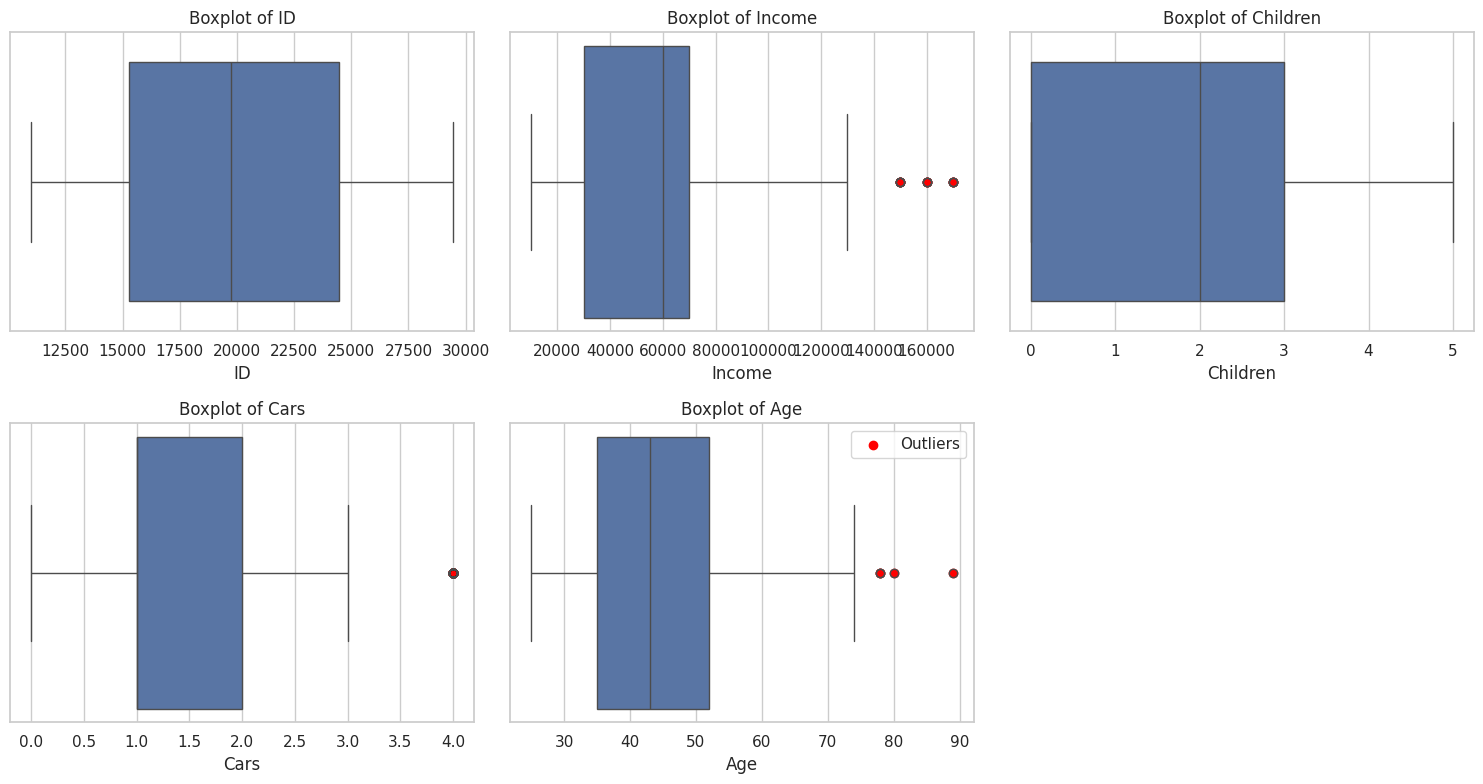

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_outliers(X_numerical, outliers_dict):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(X_numerical.columns):
        plt.subplot(2, (len(X_numerical.columns) + 1) // 2, i + 1)
        sns.boxplot(x=X_numerical[col])
        outliers = outliers_dict[col]
        if outliers:
            plt.scatter([X_numerical[col].iloc[idx] for idx in outliers],
                        [0] * len(outliers),
                        color='red',
                        label='Outliers')

        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)

    plt.tight_layout()
    plt.legend()
    plt.show()


plot_outliers(X_numerical, outliers_dict)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [187]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class MeanTargetEncoderSmoothed(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns=None, numerical_columns=None, C=1):
        self.categorical_columns = categorical_columns if categorical_columns is not None else []
        self.numerical_columns = numerical_columns if numerical_columns is not None else []
        self.C = C
        self.mapping_dict = {}
        self.global_mean = None

    def fit(self, X_categorical, X_numerical, y):
        self.global_mean = y.mean()
        X_full = pd.concat([X_categorical.reset_index(drop=True), X_numerical.reset_index(drop=True)], axis=1)
        X_full['target'] = y.reset_index(drop=True)
        for col in self.categorical_columns:
            category_means = X_full.groupby(col)['target'].agg(['mean', 'count'])
            smooth_means = (category_means['mean'] * category_means['count'] + self.global_mean * self.C) / (category_means['count'] + self.C)
            self.mapping_dict[col] = smooth_means.to_dict()

        for col in self.numerical_columns:
            value_means = X_full.groupby(col)['target'].agg(['mean', 'count'])
            smooth_means = (value_means['mean'] * value_means['count'] + self.global_mean * self.C) / (value_means['count'] + self.C)
            self.mapping_dict[col] = smooth_means.to_dict()

        return self

    def transform(self, X_categorical, X_numerical):
        X_combined = pd.concat([X_categorical.reset_index(drop=True), X_numerical.reset_index(drop=True)], axis=1)
        for col in self.categorical_columns:
            X_combined[col] = X_combined[col].map(self.mapping_dict[col]).fillna(self.global_mean)
        for col in self.numerical_columns:
            X_combined[col] = X_combined[col].map(self.mapping_dict[col]).fillna(self.global_mean) #я сюда добавила замену нанов на среднее, а не медиану, потому что выбросов мало, и они не особо влияют на значение переменной

        return X_combined

In [188]:
categorical_columns = X_categorical.columns
numerical_columns = X_numerical.columns

In [189]:
transformer = MeanTargetEncoderSmoothed(categorical_columns=categorical_columns, numerical_columns=numerical_columns)

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15)

categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X_train.select_dtypes(include=['number']).columns.tolist()

In [191]:
transformer = MeanTargetEncoderSmoothed(categorical_columns=categorical_columns, numerical_columns=numerical_columns)
transformer.fit(X_train[categorical_columns], X_train[numerical_columns], y_train)
X_train_encoded = transformer.transform(X_train[categorical_columns], X_train[numerical_columns])
X_test_encoded = transformer.transform(X_test[categorical_columns], X_test[numerical_columns])

In [192]:
start_time = time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)
end_time = time()

y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

training_time = end_time - start_time

auc_pr, training_time

(0.6535712745687773, 0.011323928833007812)

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ *Плюсы* :


*   Не создается очень много колонок
*   Устойчивость к разреженности
*   Метрики качества могут оказаться лучше из-за лучшего учета таргета

*Минусы* :


*   Потенциальная утечка данных и переобучение
*   Необходимость в кросс-валидации, что часто очень долго и дорого




# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [193]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-11-28 16:55:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.6’

adult.data.6            [     <=>            ]   3.79M  3.65MB/s    in 1.0s    

2024-11-28 16:55:08 (3.65 MB/s) - ‘adult.data.6’ saved [3974305]



In [194]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
4615,20,Private,120601,HS-grad,9,Never-married,Transport-moving,Own-child,Black,Male,0,0,40,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [195]:
X = df.drop('income', axis=1)
y = df['income']


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [196]:
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_columns]))
X_encoded.columns = encoder.get_feature_names_out(categorical_columns)
X = X.drop(categorical_columns, axis=1)
X = pd.concat([X, X_encoded], axis=1)

X.head()


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,...,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ ?,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50,83311,13,0,0,13,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38,215646,9,0,0,40,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53,234721,7,0,0,40,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28,338409,13,0,0,40,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0

In [197]:
print(f'новых признаков: {X.shape[1] - (df.shape[1] - 1)}')

новых признаков: 94


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 777 , stratify=y)

In [199]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:, 1]

average_precision = average_precision_score(y_test, y_scores)
average_precision

0.7249003719253174

Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [200]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [201]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=777, stratify=y_train_full)

In [202]:

start_time = time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
weights = model.coef_[0]
importance = np.abs(weights)
top_40_indices = np.argsort(importance)[-40:]
y_scores = model.predict_proba(X_test)[:, 1]

X_train_selected = X_train.iloc[:, top_40_indices].values
X_val_selected = X_val.iloc[:, top_40_indices].values
X_test_selected = X_test.iloc[:, top_40_indices].values

end_time = time()
selection_time = end_time - start_time
average_precision = average_precision_score(y_test, y_scores)
average_precision, selection_time

(0.7237762167355019, 9.515384435653687)

Изменилось ли качество? Как?

Оно немного, но упало.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [203]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

start_time = time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
weights = model.coef_[0]
importance = np.abs(weights)
top_40_indices = np.argsort(importance)[-40:]

X_train_selected = X_train_scaled[:, top_40_indices]
X_val_selected = X_val_scaled[:, top_40_indices]
X_test_selected = X_test_scaled[:, top_40_indices]

end_time = time()
selection_time = end_time - start_time

selection_time

0.14247727394104004

In [204]:
model_all_features = model
y_scores_all_features = model_all_features.predict_proba(X_test)[:, 1]
average_precision_all_features = average_precision_score(y_test, y_scores_all_features)
average_precision_all_features
selected_feature = X_train.columns[top_40_indices]

In [205]:
selected_feature

Index(['education_ 7th-8th', 'occupation_ Protective-serv',
       'education_ HS-grad', 'relationship_ Other-relative',
       'workclass_ Self-emp-not-inc', 'native-country_ Columbia',
       'marital-status_ Married-spouse-absent', 'occupation_ Tech-support',
       'marital-status_ Widowed', 'relationship_ Unmarried',
       'native-country_ Outlying-US(Guam-USVI-etc)',
       'occupation_ Handlers-cleaners', 'workclass_ Federal-gov',
       'education_ 11th', 'workclass_ Without-pay', 'relationship_ Husband',
       'education_ Prof-school', 'occupation_ Prof-specialty',
       'education_ Doctorate', 'education_ Bachelors', 'education_ Masters',
       'marital-status_ Separated', 'sex_ Male', 'sex_ Female',
       'occupation_ Farming-fishing', 'relationship_ Wife',
       'relationship_ Not-in-family', 'marital-status_ Divorced',
       'occupation_ Exec-managerial', 'capital-loss',
       'occupation_ Other-service', 'relationship_ Own-child', 'age',
       'occupation_ Priv-h

In [206]:
model_selected = model
model_selected.fit(X_train_selected, y_train)
y_test_scores_selected = model_selected.predict_proba(X_test_selected)[:, 1]
average_precision_test_selected = average_precision_score(y_test, y_test_scores_selected)
average_precision_test_selected

0.7609167831132568

Метрики качества возросли:)

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [207]:
df.dtypes

,0
age,int64
workclass,object
fnlwgt,int64
education,object
education-num,int64
marital-status,object
occupation,object
relationship,object
race,object
sex,object


In [208]:
X = df.drop('income', axis=1)
y = df['income']

In [209]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [210]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=777, stratify=y_train_full)

In [211]:
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [212]:
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

Для чистоты эксперимента я заново разбила всю выборку и переписала процесс обработки данных, чтобы точно учесть, что OHE тоже будет масштабироваться.

In [213]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', Pipeline(steps=[
            ('ohe', OneHotEncoder(sparse_output =False)),
            ('scaler', StandardScaler())
        ]), categorical_features)
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])
start_time = time()
pipeline.fit(X_train, y_train)
weights = pipeline.named_steps['model'].coef_[0]

importance = np.abs(weights)
top_40_indices = np.argsort(importance)[-40:]
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe']
feature_names = np.concatenate([numerical_features, ohe.get_feature_names_out(categorical_features)])
selected_feature_names = feature_names[top_40_indices]


X_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_train_selected = X_transformed[:, top_40_indices]
X_val_selected = pipeline.named_steps['preprocessor'].transform(X_val)[:, top_40_indices]
X_test_selected = pipeline.named_steps['preprocessor'].transform(X_test)[:, top_40_indices]

end_time = time()

selection_time = end_time - start_time

selection_time

0.43295836448669434

In [214]:
model_selected = LogisticRegression(max_iter=1000)
model_selected.fit(X_train_selected, y_train)
y_scores_selected = model_selected.predict_proba(X_test_selected)[:, 1]
average_precision_selected = average_precision_score(y_test, y_scores_selected)

In [215]:
average_precision_selected

0.7609165709776241

In [216]:
selected_feature_names

array(['education_ 7th-8th', 'occupation_ Protective-serv',
       'education_ HS-grad', 'relationship_ Other-relative',
       'workclass_ Self-emp-not-inc', 'native-country_ Columbia',
       'marital-status_ Married-spouse-absent',
       'occupation_ Tech-support', 'marital-status_ Widowed',
       'relationship_ Unmarried',
       'native-country_ Outlying-US(Guam-USVI-etc)',
       'occupation_ Handlers-cleaners', 'workclass_ Federal-gov',
       'education_ 11th', 'workclass_ Without-pay',
       'relationship_ Husband', 'education_ Prof-school',
       'occupation_ Prof-specialty', 'education_ Doctorate',
       'education_ Bachelors', 'education_ Masters',
       'marital-status_ Separated', 'sex_ Male', 'sex_ Female',
       'occupation_ Farming-fishing', 'relationship_ Wife',
       'relationship_ Not-in-family', 'marital-status_ Divorced',
       'occupation_ Exec-managerial', 'capital-loss',
       'occupation_ Other-service', 'relationship_ Own-child', 'age',
       'occu

In [217]:
symmetric_difference = np.setxor1d(selected_feature, selected_feature_names)
symmetric_difference

array([], dtype=object)

Как видим из результатов эксперимента, без разницы, масштабируем ли мы дополнительно значения после кодирования или нет.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Корреляция может помочь вручную отобрать потенциально значимые признаки и проверить на адекватость полученную модель. Оценка корреляционной матрицы позволяет поставить ряд гипотез о таргете и потом проверить их.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [218]:
encoder = OneHotEncoder(sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_columns]))
X_encoded.columns = encoder.get_feature_names_out(categorical_columns)
X = X.drop(categorical_columns, axis=1)
X = pd.concat([X, X_encoded], axis=1)

In [219]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [220]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=777, stratify=y_train_full)

In [221]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [222]:
start_time = time()
correlation = X_val.corrwith(y_val)

top_features_indices = correlation.abs().nlargest(40).index

X_train_top_features = X_train[top_features_indices].values
X_val_top_features = X_val[top_features_indices].values
X_test_top_features = X_test[top_features_indices].values

logreg_top_features = LogisticRegression(max_iter=1000)
logreg_top_features.fit(X_train_top_features, y_train)

y_pred_top_features = logreg_top_features.predict_proba(X_val_top_features)[:, 1]
auc_pr_top_features = average_precision_score(y_val, y_pred_top_features)

end_time = time()
execution_time = end_time - start_time

auc_pr_top_features, execution_time

(0.7654631988054958, 4.856950044631958)

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [223]:
def calculate_t_statistics(X, y):
    t_statistics = []
    for j in range(X.shape[1]):
        positive_class = X[y == 1, j]
        negative_class = X[y == 0, j]
        mu_pos, mu_neg = np.mean(positive_class), np.mean(negative_class)
        std_pos, std_neg = np.std(positive_class), np.std(negative_class)
        n_pos, n_neg = len(positive_class), len(negative_class)
        t_stat = np.abs(mu_pos - mu_neg) / np.sqrt(((n_pos * std_pos**2 + n_neg * std_neg**2) / (n_pos + n_neg)))
        t_statistics.append(abs(t_stat))
    return np.array(t_statistics)

start_time = time()
t_statistics = calculate_t_statistics(X_train.values, y_train.values)
top_features_indices = np.argsort(t_statistics)[-40:]

X_train_top_features = X_train_scaled[:, top_features_indices]
X_val_top_features = X_val_scaled[:, top_features_indices]
X_test_top_features = X_test_scaled[:, top_features_indices]

logreg_top_features = LogisticRegression()
logreg_top_features.fit(X_train_top_features, y_train)

y_pred_top_features = logreg_top_features.predict_proba(X_val_top_features)[:, 1]
auc_pr_top_features = average_precision_score(y_val, y_pred_top_features)
end_time = time()

execution_time = end_time - start_time
auc_pr_top_features, execution_time


(0.7693382209578112, 0.2956843376159668)

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [224]:
def calculate_t_statistics(X, y):
    t_statistics = []
    for j in range(X.shape[1]):
        positive_class = X[y == 1, j]
        negative_class = X[y == 0, j]

        if len(positive_class) == 0 or len(negative_class) == 0:
            t_statistics.append(0)
            continue

        mu_pos = np.mean(positive_class)
        mu_neg = np.mean(negative_class)
        std_pos = np.std(positive_class)
        std_neg = np.std(negative_class)
        n_pos = len(positive_class)
        n_neg = len(negative_class)

        if std_pos == 0 and std_neg == 0:
            t_stat = 0
        else:
            t_stat = np.abs(mu_pos - mu_neg) / np.sqrt(((n_pos * std_pos**2 + n_neg * std_neg**2) / (n_pos + n_neg)))

        t_statistics.append(t_stat)

    return np.array(t_statistics)

k = 40
m = 5   #длина шага будет определяться тем, сколькими параметрами мы можем пожертвовать при каждой итерации. У нас их больше 100, поэтому 5 - это не много и не мало для данной модели


X_current = X_train.values.copy()
features_count = X_current.shape[1]

start_time = time()
remaining_indices = list(range(features_count))

while features_count > k:
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_current, y_train)
    t_stats = calculate_t_statistics(X_current, y_train)
    least_important_indices = np.argsort(t_stats)[:min(m, features_count - k)]
    X_current = np.delete(X_current, least_important_indices, axis=1)
    features_count = X_current.shape[1]
    remaining_indices = [i for j, i in enumerate(remaining_indices) if j not in least_important_indices]

logreg_final = LogisticRegression(max_iter=1000)
logreg_final.fit(X_train.values[:, remaining_indices], y_train)
y_pred_final = logreg_final.predict_proba(X_val.values[:, remaining_indices])[:, 1]
auc_pr_final = average_precision_score(y_val, y_pred_final)

end_time = time()
execution_time = end_time - start_time

print("AUC-PR:", auc_pr_final)
print("Time for feature selection:", execution_time)

AUC-PR: 0.7656279233370137
Time for feature selection: 80.13998222351074


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [225]:
def calculate_t_statistics(X, y):
    t_statistics = []
    for j in range(X.shape[1]):
        positive_class = X[y == 1, j]
        negative_class = X[y == 0, j]

        if len(positive_class) == 0 or len(negative_class) == 0:
            t_statistics.append(0)
            continue

        mu_pos = np.mean(positive_class)
        mu_neg = np.mean(negative_class)
        std_pos = np.std(positive_class)
        std_neg = np.std(negative_class)
        n_pos = len(positive_class)
        n_neg = len(negative_class)

        if std_pos == 0 and std_neg == 0:
            t_stat = 0
        else:
            t_stat = np.abs(mu_pos - mu_neg) / np.sqrt(((n_pos * std_pos**2 + n_neg * std_neg**2) / (n_pos + n_neg)))

        t_statistics.append(t_stat)

    return np.array(t_statistics)

k = 40
m = 5

X_current = np.empty((X_train.shape[0], 0))
features_count = X_train.shape[1]
remaining_indices = list(range(features_count))

start_time = time()

while X_current.shape[1] < k:
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train.values[:, remaining_indices], y_train)

    t_stats = calculate_t_statistics(X_train.values[:, remaining_indices], y_train)
    most_important_indices = np.argsort(t_stats)[-m:]
    for index in most_important_indices:
        if index not in remaining_indices:
            remaining_indices.append(index)

    X_current = X_train.values[:, remaining_indices]

logreg_final = LogisticRegression(max_iter=1000)
logreg_final.fit(X_current, y_train)
y_pred_final = logreg_final.predict_proba(X_val.values[:, remaining_indices])[:, 1]
auc_pr_final = average_precision_score(y_val, y_pred_final)

end_time = time()
execution_time = end_time - start_time

print("AUC-PR:", auc_pr_final)
print("Time for feature selection:", execution_time)

AUC-PR: 0.7314388294859614
Time for feature selection: 12.185384035110474


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Метод фильтрации по корреляции очень прост в реализации и интуитивно понятен, дает неплохие метрики качества, но неспособен учитывать нелинейные связи между коэффициентами, а также не учитывает совокупную значимость признаков, которые по отдельности могут не оказывать эффекта, но вместе действительно обладают предсказательной силой.

Метод отбора по т-статистике дает лучшие метрики качества, но при этом требует достаточно большую выборку, нормализацию данных, а также может быть очень чувствительна к выбросам.

Последние два метода проигрывают предыдущим и по сложности, и по метрикам. Вероятно, дело в сложности подбора оптимального шага, но решение задачи оптимизации шага - это дополнительная проблема для реализации этого алгоритма.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [226]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-11-28 16:57:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.3’

bank-additional.zip     [   <=>              ] 434.15K   671KB/s    in 0.6s    

2024-11-28 16:57:16 (671 KB/s) - ‘bank-additional.zip.3’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: bank-additional/.DS_Store  
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [227]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [228]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [229]:
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6


In [230]:
X.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
housing,object
loan,object
contact,object
month,object
day_of_week,object


В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [231]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

def cross_validate(
    X,
    y,
    n_splits= 5,
    random_state= 421,
    shuffle= True,
):
    metrics = []


    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ],
        remainder='passthrough'
    )

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=random_state))
        ])
        model_pipeline.fit(X_train, y_train)
        y_pred = model_pipeline.predict(X_test)
        roc_auc = roc_auc_score(y_test, y_pred)

        metric_dict = {
            "ROC-AUC": roc_auc
        }
        metrics.append(metric_dict)

    return pd.DataFrame(metrics)


Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [232]:
results = cross_validate(X, y, n_splits=10, random_state=42, shuffle=True)
print(results)

    ROC-AUC
0  0.606253
1  0.594075
2  0.616790
3  0.604545
4  0.614211
5  0.610172
6  0.598359
7  0.620123
8  0.597017
9  0.611302


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [233]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=421,
    shuffle=True,
):
    metrics = []

    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ],
        remainder='passthrough'
    )

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=random_state))
        ])

        model_pipeline.fit(X_train, y_train)
        y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

        threshold = 0.5
        y_pred = (y_pred_proba >= threshold).astype(int)

        roc_auc = roc_auc_score(y_test, y_pred_proba)

        revenue_per_successful_call = 10
        cost_per_call = 2
        profit_per_successful_call = revenue_per_successful_call - cost_per_call

        successful_calls_count = successful_calls_count = sum((y_pred == 1) & (y_test == 1))
        all_calls = y_pred.sum()
        total_revenue = successful_calls_count * revenue_per_successful_call
        total_costs = all_calls * cost_per_call
        total_profit = total_revenue - total_costs

        metrics.append({
            "ROC-AUC": roc_auc,
            "Total Profit": total_profit,
            "Total Revenue": total_revenue,
            "Total Costs": total_costs,
            "Successful Calls": successful_calls_count,
        })

    return pd.DataFrame(metrics)

results_df = cross_validate(X, y)
results_df

,ROC-AUC,Total Profit,Total Revenue,Total Costs,Successful Calls
0,0.784218,1432,2060,628,206
1,0.796653,1414,2040,626,204
2,0.784572,1516,2200,684,220
3,0.794550,1460,2110,650,211
4,0.796318,1502,2090,588,209


In [234]:
std = results_df['Total Profit'].std()
std

43.83149552547802

In [235]:
avg = results_df['Total Profit'].mean()
costs = results_df['Total Costs'].mean()

In [236]:
avg

1464.8

In [237]:
costs

635.2

In [238]:
corr = results_df['ROC-AUC'].corr(results_df['Total Profit']) #судя по отрицательной парной корреляции, можно даже не считать пропорциональность
corr

-0.19224061478709342

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [239]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def cross_validate(
    X,
    y,
    n_splits=5,
    shuffle=True,
):
    metrics = []

    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ],
        remainder='passthrough'
    )

    kf = KFold(n_splits=n_splits, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression())
        ])

        model_pipeline.fit(X_train, y_train)
        y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
        threshold = 0.5
        y_pred = (y_pred_proba >= threshold).astype(int)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        cost_per_call = 2
        revenue_per_successful_call = lambda: np.random.uniform(0, 20)
        successful_calls_count = sum((y_pred == 1) & (y_test == 1))
        total_revenue = sum(revenue_per_successful_call() for _ in range(successful_calls_count))
        all_calls = y_pred.sum()
        total_profit = total_revenue - all_calls * cost_per_call
        total_costs = all_calls * cost_per_call

        metrics.append({
            "ROC-AUC": roc_auc,
            "Total Profit": total_profit,
            "Total Revenue": total_revenue,
            "Total Costs": total_costs,
            "Successful Calls": successful_calls_count,
        })

    return pd.DataFrame(metrics)


results_df = cross_validate(X, y)
results_df

mean_profit = results_df['Total Profit'].mean()
mean_revenue = results_df['Total Revenue'].mean()
mean_costs = results_df['Total Costs'].mean()


In [240]:
results_df

,ROC-AUC,Total Profit,Total Revenue,Total Costs,Successful Calls
0,0.798388,1658.137920,2254.137920,596,211
1,0.781592,1436.673121,2082.673121,646,214
2,0.785400,1420.857431,2090.857431,670,212
3,0.788740,1439.327656,2043.327656,604,198
4,0.805197,1751.344694,2395.344694,644,223


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

Максимальная прибыль: 1518.25 при коэффициенте регуляризации: 1291.5497


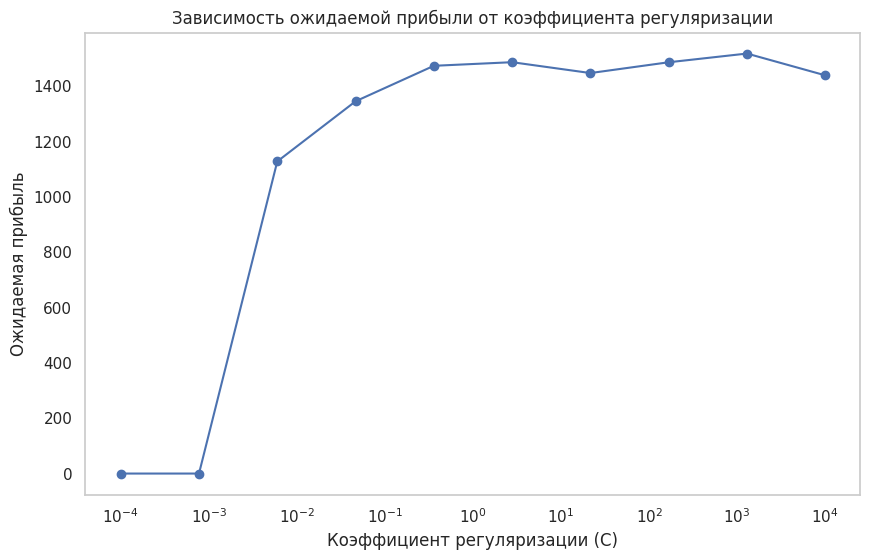

In [241]:

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def cross_validate_profit(X, y, regularization_strengths, n_splits=5, random_state=421, shuffle=True):
    results = []

    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ],
        remainder='passthrough'
    )
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for C in regularization_strengths:
        total_profit = 0

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model_pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', LogisticRegression(C=C, random_state=random_state))
            ])

            model_pipeline.fit(X_train, y_train)
            y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
            threshold = 0.5
            y_pred = (y_pred_proba >= threshold).astype(int)
            cost_per_call = 2
            successful_calls_count = sum((y_pred == 1) & (y_test == 1))
            all_calls = y_pred.sum()
            total_cost = all_calls * cost_per_call
            profit_from_successful_calls = sum(np.random.uniform(0, 20) for _ in range(successful_calls_count))
            total_profit += profit_from_successful_calls - total_cost

        average_profit = total_profit / n_splits
        results.append((C, average_profit))

    return results
regularization_strengths = np.logspace(-4, 4, 10)

results = cross_validate_profit(X, y, regularization_strengths)
results_df = pd.DataFrame(results, columns=['Regularization Strength (C)', 'Average Profit'])
max_profit_row = results_df.loc[results_df['Average Profit'].idxmax()]
max_profit_value = max_profit_row['Average Profit']
best_regularization_strength = max_profit_row['Regularization Strength (C)']

print(f"Максимальная прибыль: {max_profit_value:.2f} при коэффициенте регуляризации: {best_regularization_strength:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(results_df['Regularization Strength (C)'], results_df['Average Profit'], marker='o')
plt.xscale('log')
plt.title('Зависимость ожидаемой прибыли от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации (C)')
plt.ylabel('Ожидаемая прибыль')
plt.grid()
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Нет, закономерности не наблюдается. Видимо, элемент случайности сильно меняет потенциальную необходимость в регуляризации модели.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Нужно понять, что стоит для нас дороже: ложноположительные или ложноотрицательные предсказания модели. В данном случае, я бы сказала, что из-за низкой относительной стоимости звонка клиенту, предпочтительнее все же позвонить, даже если он не намеревался соглашаться на услугу, в то время как пропуск истинно положительных значений может обернуться большими убытками. Поэтому кажется, что высокая полнота может быть оптимальной метрикой в случае этого бизнеса.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

Maximum Profit: 2890.63 at Threshold: 0.21


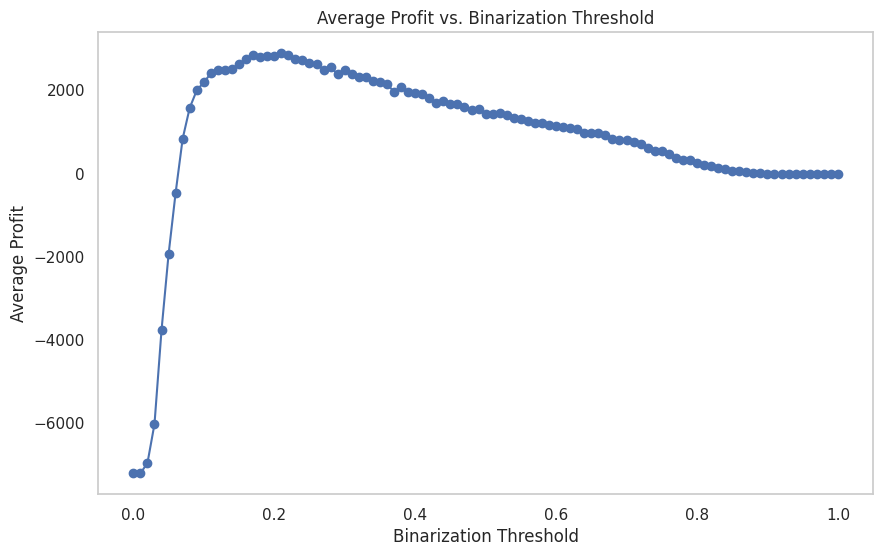

In [243]:
def cross_validate_profit_with_threshold(X, y, thresholds, n_splits=5, random_state=421, shuffle=True):
    results = []

    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ],
        remainder='passthrough'
    )

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for threshold in thresholds:
        total_profit = 0

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model_pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', LogisticRegression(random_state=random_state))
            ])

            model_pipeline.fit(X_train, y_train)
            y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
            y_pred = (y_pred_proba >= threshold).astype(int)
            cost_per_call = 2
            successful_calls_count = sum((y_pred == 1) & (y_test == 1))
            all_calls = y_pred.sum()
            total_cost = all_calls * cost_per_call
            profit_from_successful_calls = sum(np.random.uniform(0, 20) for _ in range(successful_calls_count))
            total_profit += profit_from_successful_calls - total_cost

        average_profit = total_profit / n_splits
        results.append((threshold, average_profit))

    return results
thresholds = np.arange(0, 1.01, 0.01)
results = cross_validate_profit_with_threshold(X, y, thresholds)
results_df = pd.DataFrame(results, columns=['Threshold', 'Average Profit'])

max_profit_row = results_df.loc[results_df['Average Profit'].idxmax()]
max_profit_value = max_profit_row['Average Profit']
best_threshold = max_profit_row['Threshold']

print(f"Maximum Profit: {max_profit_value:.2f} at Threshold: {best_threshold:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Average Profit'], marker='o')
plt.title('Average Profit vs. Binarization Threshold')
plt.xlabel('Binarization Threshold')
plt.ylabel('Average Profit')
plt.grid()
plt.show()



Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог





__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Значения регуляризации всегда колеблются около 0,16-0,25, что логично, потому что издержки на ложноположительный результат модели = 0,2 от выгод при верноположительном результате.

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

Максимальная прибыль: 3040.70 при коэффициенте регуляризации: 0.3594


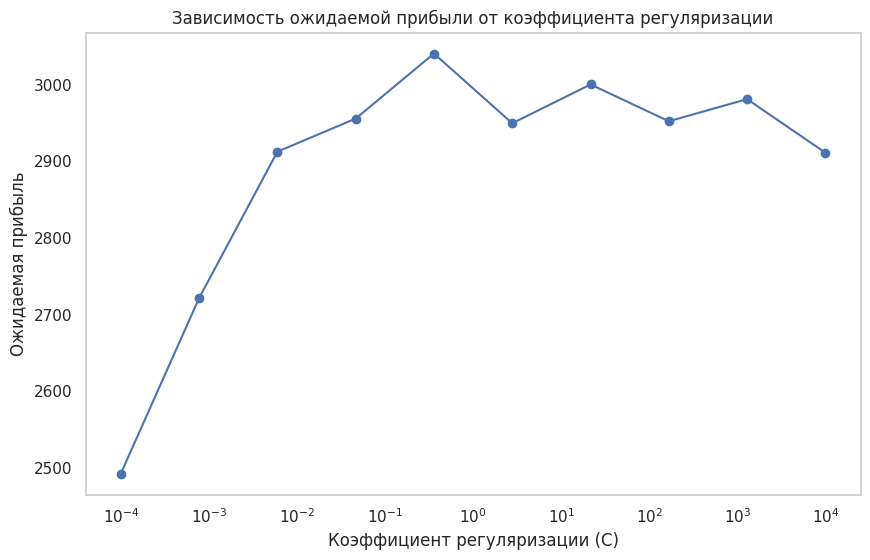

Оптимизированная модель: Средняя прибыль: 3040.70, Стандартное отклонение: 164.04
Дефолтная модель: Средняя прибыль: 1478.17, Стандартное отклонение: 108.35
t-статистика: -28.8418, p-значение: 0.0000
Существует статистически значимая разница в прибыли между моделями.


In [244]:

from scipy import stats

def cross_validate_profit(X, y, regularization_strengths, n_splits=5, random_state=421, shuffle=True):
    results = []

    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ],
        remainder='passthrough'
    )

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for C in regularization_strengths:
        total_profit = 0

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model_pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', LogisticRegression(C=C, random_state=random_state))
            ])

            model_pipeline.fit(X_train, y_train)
            y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
            best_profit = float('-inf')
            best_threshold = 0.5

            for threshold in np.arange(0, 1.01, 0.01):
                y_pred = (y_pred_proba >= threshold).astype(int)
                successful_calls_count = sum((y_pred == 1) & (y_test == 1))
                all_calls = y_pred.sum()
                revenue_from_successful_calls = sum(np.random.uniform(0, 20) for _ in range(successful_calls_count))
                cost_per_call = 2
                total_profit_for_threshold = revenue_from_successful_calls - (cost_per_call * all_calls)
                if total_profit_for_threshold > best_profit:
                    best_profit = total_profit_for_threshold
                    best_threshold = threshold

            total_profit += best_profit

        average_profit = total_profit / n_splits
        results.append((C, average_profit))

    return results

regularization_strengths = np.logspace(-4, 4, 10)

results = cross_validate_profit(X, y, regularization_strengths)

results_df = pd.DataFrame(results, columns=['Regularization Strength (C)', 'Average Profit'])
max_profit_row = results_df.loc[results_df['Average Profit'].idxmax()]
max_profit_value = max_profit_row['Average Profit']
best_regularization_strength = max_profit_row['Regularization Strength (C)']

print(f"Максимальная прибыль: {max_profit_value:.2f} при коэффициенте регуляризации: {best_regularization_strength:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(results_df['Regularization Strength (C)'], results_df['Average Profit'], marker='o')
plt.xscale('log')
plt.title('Зависимость ожидаемой прибыли от коэффициента регуляризации')
plt.xlabel('Коэффициент регуляризации (C)')
plt.ylabel('Ожидаемая прибыль')
plt.grid()
plt.show()


def cross_validate_default(X, y, n_splits=5, random_state=421, shuffle=True):
    metrics = []
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ],
        remainder='passthrough'
    )

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_pipeline_default = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=random_state))
        ])

        model_pipeline_default.fit(X_train, y_train)
        y_pred_proba_default = model_pipeline_default.predict_proba(X_test)[:, 1]
        threshold_default = 0.5
        y_pred_default = (y_pred_proba_default >= threshold_default).astype(int)
        successful_calls_count_default = sum((y_pred_default == 1) & (y_test == 1))
        all_calls_default = y_pred_default.sum()
        revenue_from_successful_calls_default = sum(np.random.uniform(0, 20) for _ in range(successful_calls_count_default))
        cost_per_call = 2
        total_profit_default = revenue_from_successful_calls_default - (cost_per_call * all_calls_default)

        metrics.append(total_profit_default)

    return metrics
default_profits = cross_validate_default(X, y)
mean_profit_optimized = results_df['Average Profit'].max()
std_profit_optimized = results_df['Average Profit'].std()

mean_profit_default = np.mean(default_profits)
std_profit_default = np.std(default_profits)

print(f"Оптимизированная модель: Средняя прибыль: {mean_profit_optimized:.2f}, Стандартное отклонение: {std_profit_optimized:.2f}")
print(f"Дефолтная модель: Средняя прибыль: {mean_profit_default:.2f}, Стандартное отклонение: {std_profit_default:.2f}")
t_statistic, p_value = stats.ttest_rel(default_profits, [mean_profit_optimized] * len(default_profits))
print(f"t-статистика: {t_statistic:.4f}, p-значение: {p_value:.4f}")
if p_value < 0.05:
    print("Существует статистически значимая разница в прибыли между моделями.")
else:
    print("Нет статистически значимой разницы в прибыли между моделями.")

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ слезы